# Name Encoder-Decoder

Now try an encoder decoder. Rather than classifying the country, let's encode the name; and feed a decoder a '<sos>' token and see if it can generate the country sequentially.

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


from common.utils import (
    load_language,
)

import torch
from torch.utils.data import Subset
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Globals

In [2]:
seed_everything(2718)

Seed set to 2718


2718

In [3]:
# File paths
NAMES_INPUT_PATH = "../data/processed/names.txt"
NAMES_INDICES_INPUT_PATH = "../data/processed/names_indices.txt"
COUNTRY_INPUT_PATH = "../data/processed/countries.txt"
COUNTRY_LETTER_INDICES_INPUT_PATH = (
    "../data/processed/countries_letter_indices.txt"
)

# Language model paths
NAMES_MODEL_PATH = "../models/names_model.pkl"
COUNTRIES_LETTER_MODEL_PATH = "../models/countries_letter_model.pkl"


# Training params
EPOCHS = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 1024
UNIT_TYPE = "GRU"
ACCELERATOR = "gpu"

# CPUS to give each dataloader
NUM_WORKERS = 4

In [4]:
# Load the language models
names_language = load_language(NAMES_MODEL_PATH)
countries_language = load_language(COUNTRIES_LETTER_MODEL_PATH)

NAME_VOCAB_SIZE = len(names_language.vocabulary)
COUNTRY_VOCAB_SIZE = len(countries_language.vocabulary)

print(f"Name vocab size: {NAME_VOCAB_SIZE}")
print(f"Country vocab size: {COUNTRY_VOCAB_SIZE}")

INFO:common.utils:Loading from ../models/names_model.pkl
INFO:common.utils:Creating a language object for names
INFO:common.utils:Loading from ../models/countries_letter_model.pkl
INFO:common.utils:Creating a language object for countries_letters


Name vocab size: 91
Country vocab size: 35


## Utilities

In [5]:
class NamesDataset(torch.utils.data.Dataset):
    """
    Dataset for the names dataset.
    """

    def __init__(
        self,
        names_path,
        countries_path,
        name_indices_path,
        country_indices_path,
    ):
        self.names_path = names_path
        self.countries_path = countries_path
        self.name_indices_path = name_indices_path
        self.country_indices_path = country_indices_path

        self.names = []
        self.countries = []
        self.name_indices = []
        self.country_indices = []

        # Load files
        self._load_data()

        return None

    def _load_label_data(self, path):
        """
        Load in a file where each line is a sentence.
        """
        with open(path, "r") as f:
            data = f.readlines()

        data = [x.strip() for x in data]

        return data

    def _load_index_data(self, path):
        """
        Load in a file where each line is a list of indices.
        """
        with open(path, "r") as f:
            data = f.readlines()

        data = [x.strip().split(" ") for x in data]
        data = [[int(x) for x in y] for y in data]

        return data

    def _load_data(self):
        names = self._load_label_data(self.names_path)
        self.names = names

        countries = self._load_label_data(self.countries_path)
        self.countries = countries

        name_indices = self._load_index_data(self.name_indices_path)
        self.name_indices = name_indices

        country_indices = self._load_index_data(self.country_indices_path)
        self.country_indices = country_indices

        return None

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        names = self.names[idx]
        country = self.countries[idx]

        name_indices = self.name_indices[idx]
        country_indices = self.country_indices[idx]

        # Convert to tensors
        name_indices = torch.tensor(name_indices).long()
        country_indices = torch.tensor(country_indices).long()

        return name_indices, country_indices, names, country

In [6]:
def custom_collate_fn(batch):
    """
    We receive a list of tuples 4 long.
    Each tuple is a tokenized name, a tokenized country (which is one-hot),
    the name, and the country as strings.

    We want to pad and stack them.
    """

    x = [item[0] for item in batch]
    y = [item[1] for item in batch]
    names = [item[2] for item in batch]
    countries = [item[3] for item in batch]

    # Lengths to pass the pack and pad sequence function
    x_len = [len(item) for item in x]
    y_len = [len(item) for item in y]

    # Pad the sequences
    x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)

    # Now since we're teacher forcing we need two versions of y. One with
    # missing the start token, y_target, and one with missing the end token,
    # y_input
    y_target = y[:, 1:]
    y_input = y[:, :-1]

    return x, y_input, y_target

In [7]:
dataset = NamesDataset(
    names_path=NAMES_INPUT_PATH,
    countries_path=COUNTRY_INPUT_PATH,
    name_indices_path=NAMES_INDICES_INPUT_PATH,
    country_indices_path=COUNTRY_LETTER_INDICES_INPUT_PATH,
)

In [8]:
# Inspect a random sample
# Show random example
x, y, name, country = dataset[np.random.randint(0, len(dataset))]
print("Input: ", x)
print("Target: ", y)
print("Name: ", name)
print("Country: ", country)

# And our language model can invert the indices
print("\nInput: ", names_language.index_to_token(x))
print("Target: ", countries_language.index_to_token(y))

Input:  tensor([ 2, 39,  4,  8,  7,  3])
Target:  tensor([ 2, 13,  5, 12, 11,  4,  6, 10,  3])
Name:  Vane
Country:  English

Input:  ['<SOS>', 'V', 'a', 'n', 'e', '<EOS>']
Target:  ['<SOS>', 'E', 'n', 'g', 'l', 'i', 's', 'h', '<EOS>']


In [9]:
train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])

In [10]:
# Make a dataloader that pulls 1 batch at a time. Note that more than 1 batch
# will throw an error since we have variable length sequences. We'd need to pass
# a custom collation function for that, which we'll do in the next notebook.
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=custom_collate_fn,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=custom_collate_fn,
)

In [11]:
# Inspect the data loader.

x, y_input, y_target = next(iter(train_dataloader))
print("X shape: ", x.shape)
print("Y input shape: ", y_input.shape)
print("Y target shape: ", y_target.shape)

# Just to be sure, decode the first row
print("\nDecode the first row")
print("X: ", names_language.index_to_token(x[0]))
print("Y input: ", countries_language.index_to_token(y_input[0]))
print("Y target: ", countries_language.index_to_token(y_target[0]))

X shape:  torch.Size([128, 19])
Y input shape:  torch.Size([128, 9])
Y target shape:  torch.Size([128, 9])

Decode the first row
X:  ['<SOS>', 'J', 'a', 'k', 'i', 'm', 'c', 'h', 'i', 'k', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Y input:  ['<SOS>', 'R', 'u', 's', 's', 'i', 'a', 'n', '<EOS>']
Y target:  ['R', 'u', 's', 's', 'i', 'a', 'n', '<EOS>', '<PAD>']


## Model

In [12]:
class NameEncoderDecoder(L.LightningModule):
    def __init__(
        self, input_vocab_len, output_vocab_len, embedding_size, hidden_size
    ):
        super().__init__()

        self.input_vocab_len = input_vocab_len
        self.output_vocab_len = output_vocab_len
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size

        self.criterion = torch.nn.NLLLoss()

        # Embedding
        self.input_embedding = torch.nn.Embedding(
            self.input_vocab_len, self.embedding_size
        )
        self.output_embedding = torch.nn.Embedding(
            self.output_vocab_len, self.embedding_size
        )

        # Encoder
        self.encoder = torch.nn.GRU(
            self.embedding_size,
            self.hidden_size,
            batch_first=True,
            dropout=0.2,
        )

        # Decoder
        # The input to the decoder will be a concat of the
        self.decoder = torch.nn.GRU(
            self.embedding_size + self.hidden_size,
            self.hidden_size,
            batch_first=True,
            dropout=0.2,
        )

        self.dense = torch.nn.Linear(self.hidden_size, self.output_vocab_len)

        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def encoder_step(self, x):
        """
        Push inputs through encoder.
        """

        # Shapes are:
        # x: (batch_size, seq_len)
        # decoder_input: (batch_size, seq_len-1)
        # decoder_target: (batch_size, seq_len-1)

        # Construct embeddings
        x = self.input_embedding(x)
        # x: (batch_size, seq_len, embedding_size)

        # Run the encoder
        encoder_output, context_vector = self.encoder(x)
        # output: (batch_size, seq_len, hidden_size)
        # context_vector: (1, batch_size, hidden_size)

        return context_vector

    def decoder_step(self, decoder_input, context_vector, decoder_state=None):
        """
        Push inputs through decoder.
        """

        # Embed target outputs
        decoder_input = self.output_embedding(decoder_input)
        # decoder_input: (batch_size, seq_len-1, embedding_size)

        # Currently the context vector is (1, batch_size, hidden_size)
        # decoder_input is (batch_size, seq_len-1, embedding_size)
        # Rather than construct a special RNN module that can handle two inputs,
        # we're simply going to concatenate the context vector to the decoder input.

        # Permute the dimensions of context vector to be conformable with decoder_input
        context_vector = context_vector.permute(1, 0, 2)
        # context_vector: (batch_size, 1, hidden_size)

        # Make copies of the context vector along the sequence length demiension
        context_vector = context_vector.repeat(1, decoder_input.shape[1], 1)
        # context_vector: (batch_size, seq_len-1, hidden_size)

        decoder_input = torch.cat([decoder_input, context_vector], dim=2)
        # decoder_input: (batch_size, seq_len-1, embedding_size + hidden_size)

        # Now run the decoder_input through the decoder
        decoder_output, decoder_state = self.decoder(
            decoder_input, decoder_state
        )
        # decoder_output: (batch_size, seq_len-1, hidden_size)

        # decoder_output is (batch_size, seq_len-1, hidden_size)
        # Add a dense layer to convert it to the decoder_output vocab size
        decoder_output = self.dense(decoder_output)
        # decoder_output: (batch_size, seq_len-1, decoder_output_vocab_size)

        # Now log softmax the decoder_output along last dimension
        decoder_output = self.log_softmax(decoder_output)
        # output: (batch_size, seq_len-1, output_vocab_size)

        return decoder_output, decoder_state

    def training_step(self, batch, batch_idx):
        x, decoder_input, decoder_target = batch

        # Get context vector
        context_vector = self.encoder_step(x)

        # Get decoder output
        decoder_output, _ = self.decoder_step(decoder_input, context_vector)
        # decoder_output: (batch_size, seq_len-1, output_vocab_size)

        # To use our NLL loss, we need to reshape the output and target
        # The outputs need to be (N, class_size) and the targets (N)
        # So flatten the batch and sequence dimensions.
        decoder_output = decoder_output.reshape(-1, self.output_vocab_len)
        decoder_target = decoder_target.reshape(-1)

        # output: (batch_size * seq_len-1, output_vocab_size)
        # decoder_target: (batch_size * seq_len-1, )

        loss = self.criterion(decoder_output, decoder_target)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Same as training step. We have the option to add more metrics here.
        """
        x, decoder_input, decoder_target = batch
        context_vector = self.encoder_step(x)

        decoder_output, _ = self.decoder_step(decoder_input, context_vector)
        decoder_output = decoder_output.reshape(-1, self.output_vocab_len)
        decoder_target = decoder_target.reshape(-1)

        loss = self.criterion(decoder_output, decoder_target)

        self.log("validation_loss", loss)

        return None

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        # One cycle learning rate scheduler
        # scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #     optimizer,
        #     max_lr=0.01,
        #     steps_per_epoch=len(train_dataloader),
        #     epochs=EPOCHS,
        # )

        # Reduce on plateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=3,
            verbose=True,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "validation_loss",
        }

    def inference(self, name: str):
        """
        Run inference on a single example.
        """
        assert isinstance(name, str)

        # Tokenize the input
        input_tokens = names_language.tokenizer(name)

        # Add <SOS> and <EOS> tokens
        input_tokens = ["<SOS>"] + input_tokens + ["<EOS>"]

        input_indices = names_language.token_to_index(input_tokens)

        x = torch.tensor(input_indices).unsqueeze(0).long()
        # x should have shape (1, seq_len)
        assert x.shape[0] == 1

        # Get context vector
        context_vector = self.encoder_step(x)

        # Now we need to run the decoder
        # We'll start with a start token and no state
        decoder_input = torch.tensor(
            [countries_language.token_to_index("<SOS>")]
        ).unsqueeze(0)
        decoder_state = None
        # decoder_input: (1, 1) and it's a long

        # We'll keep track of the output
        output = []

        reached_eos = False
        for i in range(10):
            # Run the decoder
            decoder_output, decoder_state = self.decoder_step(
                decoder_input, context_vector, decoder_state
            )
            # decoder_output: (1, 1, output_vocab_size)

            # Get the most likely token
            token = torch.argmax(decoder_output, dim=-1)
            # token: (1, 1)

            # Append to the output
            output.append(token.squeeze(0).item())

            # If we've reached the end of the sentence, break
            if token.item() == countries_language.token_to_index("<EOS>"):
                reached_eos = True
                break

            # Update the decoder input
            decoder_input = token

        if not reached_eos:
            logger.info("Failed to reach EOS token")

        # Convert the output to a string
        output = [countries_language.index_to_token(x) for x in output]
        # If the last token is <EOS> remove it
        if output[-1] == "<EOS>":
            output = output[:-1]

        output = "".join(output)

        return output

In [13]:
model = NameEncoderDecoder(
    input_vocab_len=NAME_VOCAB_SIZE,
    output_vocab_len=COUNTRY_VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
)

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

tensorboard_logger = TensorBoardLogger(
    save_dir=parent_dir,
    name="logs/name_country_encoeer_decoder",
    version=f"UNIT={UNIT_TYPE}_BATCH_SIZE={BATCH_SIZE}_EMBEDDING_SIZE={EMBEDDING_SIZE}_HIDDEN_SIZE={HIDDEN_SIZE}",
)

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
model.train()
trainer = L.Trainer(
    devices=1,
    accelerator=ACCELERATOR,
    logger=tensorboard_logger,
    max_epochs=EPOCHS,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | criterion        | NLLLoss    | 0      | train
1 | input_embedding  | Embedding  | 11.6 K | train
2 | output_embedding | Embedding  | 4.5 K  | train
3 | encoder          | GRU        | 3.5 M  | train
4 | decoder          | GRU        | 6.7 M  | train
5 | dense            | Linear     | 35.9 K | train
6 | log_softmax      | LogSoftmax | 0      | train
--------------------------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.152    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 110/110 [00:09<00:00, 11.01it/s, v_num=1024]     

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 110/110 [00:10<00:00, 10.31it/s, v_num=1024]


In [16]:
# Save the model
if not os.path.exists("../models"):
    os.makedirs("../models")

torch.save(model.state_dict(), "../models/name_country_encoder_decoder.pth")

In [34]:
model.freeze()

name = "Thompson"
model.inference(name)

'English'

In [18]:
# Run it over the dataset

for i in range(3):
    x, y, name, country = dataset[np.random.randint(0, len(dataset))]
    print("Name: ", name)
    print("Country: ", country)
    print("Predicted: ", model.inference(name))
    print("\n")

Name:  Shalnev
Country:  Russian
Predicted:  Russian


Name:  Yanagawa
Country:  Japanese
Predicted:  Japanese


Name:  Juhnin
Country:  Russian
Predicted:  Russian




In [19]:
# Evaluate accuracy:

predictions = []
for x, y, name, actual in val:
    predicted = model.inference(name)

    predictions.append((name, actual, predicted))

INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token
INFO:__main__:Failed to reach EOS token


In [20]:
# Create data frame

df = pd.DataFrame(predictions, columns=["Name", "Actual", "Predicted"])

report = classification_report(df["Actual"], df["Predicted"], zero_division=0)
print(report)

              precision    recall  f1-score   support

      Arabic       0.97      0.99      0.98       601
     Chinese       0.69      0.49      0.57        86
       Czech       0.48      0.37      0.42       150
       Dutch       0.73      0.54      0.62        83
     English       0.79      0.74      0.76      1143
      French       0.29      0.23      0.25        71
      German       0.45      0.65      0.53       223
       Greek       0.53      0.77      0.63        56
       Irish       0.52      0.34      0.41        88
     Italian       0.73      0.71      0.72       226
    Japanese       0.84      0.86      0.85       302
      Korean       0.27      0.14      0.18        29
      Polish       0.53      0.44      0.48        41
  Portuguese       0.07      0.05      0.05        22
     Russian       0.92      0.95      0.94      2762
    Scottish       0.03      0.03      0.03        34
     Spanish       0.35      0.45      0.39        85
  Vietnamese       0.83    

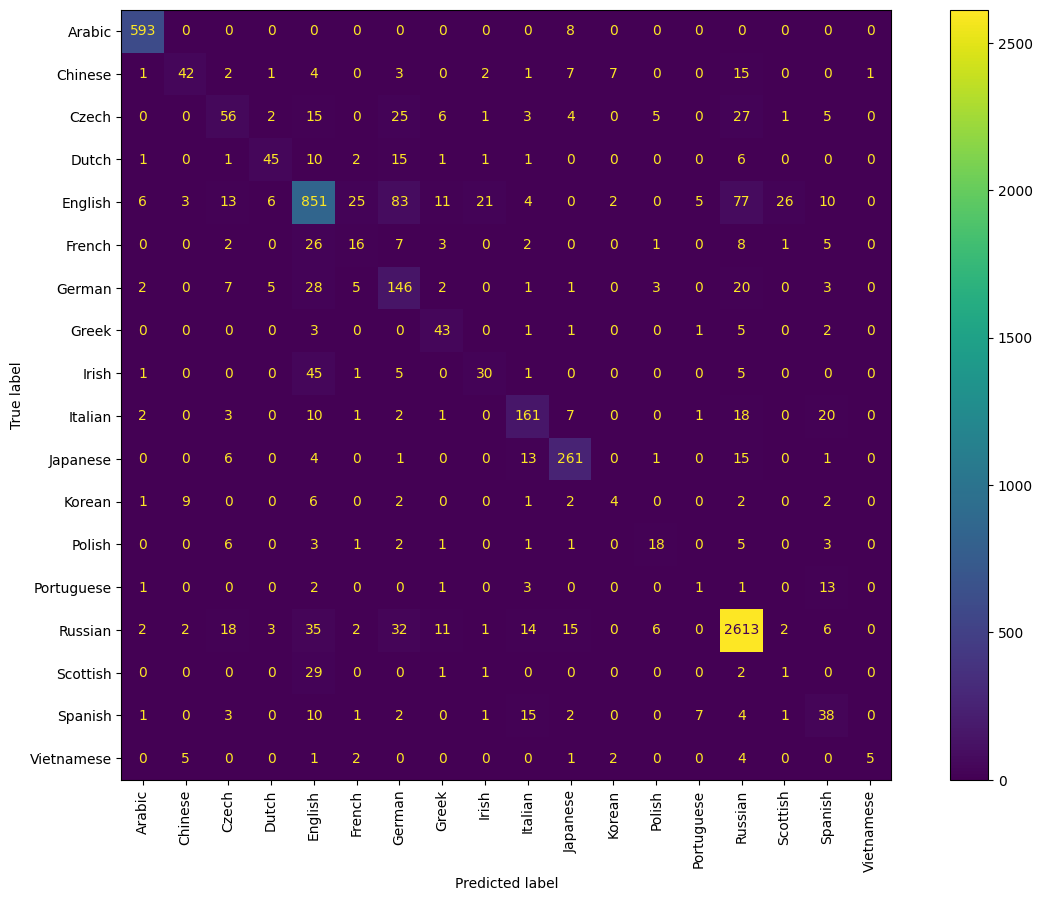

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.gca()

ConfusionMatrixDisplay.from_predictions(df["Actual"], df["Predicted"], ax=ax)

# Rotate the xtick label
plt.xticks(rotation=90)

plt.show()